In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn_features.transformers import DataFrameSelector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.linear_model import SGDRegressor

import mlflow
from hyperopt import hp, space_eval, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll import scope
from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient



In [2]:
df = pd.read_csv('./data/Diamonds_Prices2022.csv')
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In this project I will use the [Diamond Prices Dataset](https://www.kaggle.com/datasets/nancyalaswad90/diamonds-prices). This dataset contains prices and attributes for approximately 54,000 round-cut diamonds.
There are 53,940 diamonds in the dataset with 10 features (carat, cut, color, clarity, depth, table, price, x, y, and z). Most variables are numeric in nature, but the variables cut, color, and clarity are ordered factor variables with the following levels.

I want to use parts of the data to train a model that predicts the price of diamonds based on their features. To proceed, I will first do a little bit of data exploration. Let's check for `NaN`s.

In [4]:
df.isnull().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

No `Nan`s found.

In [5]:
df.describe()

,Unnamed: 0,carat,depth,table,price,x,y,z
count,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000
mean,26972.000000,0.797935,61.749322,57.457251,3932.734294,5.731158,5.734526,3.538730
std,15572.147122,0.473999,1.432626,2.234549,3989.338447,1.121730,1.142103,0.705679
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13486.500000,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,26972.000000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,40457.500000,1.040000,62.500000,59.000000,5324.000000,6.540000,6.540000,4.040000
max,53943.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [6]:
# categorical features
df.describe(include=[object])

,cut,color,clarity
count,53943,53943,53943
unique,5,7,8
top,Ideal,G,SI1
freq,21551,11292,13067


The data includes seven numeric features and three categorical features. Let's see which numerical features correlate with price.

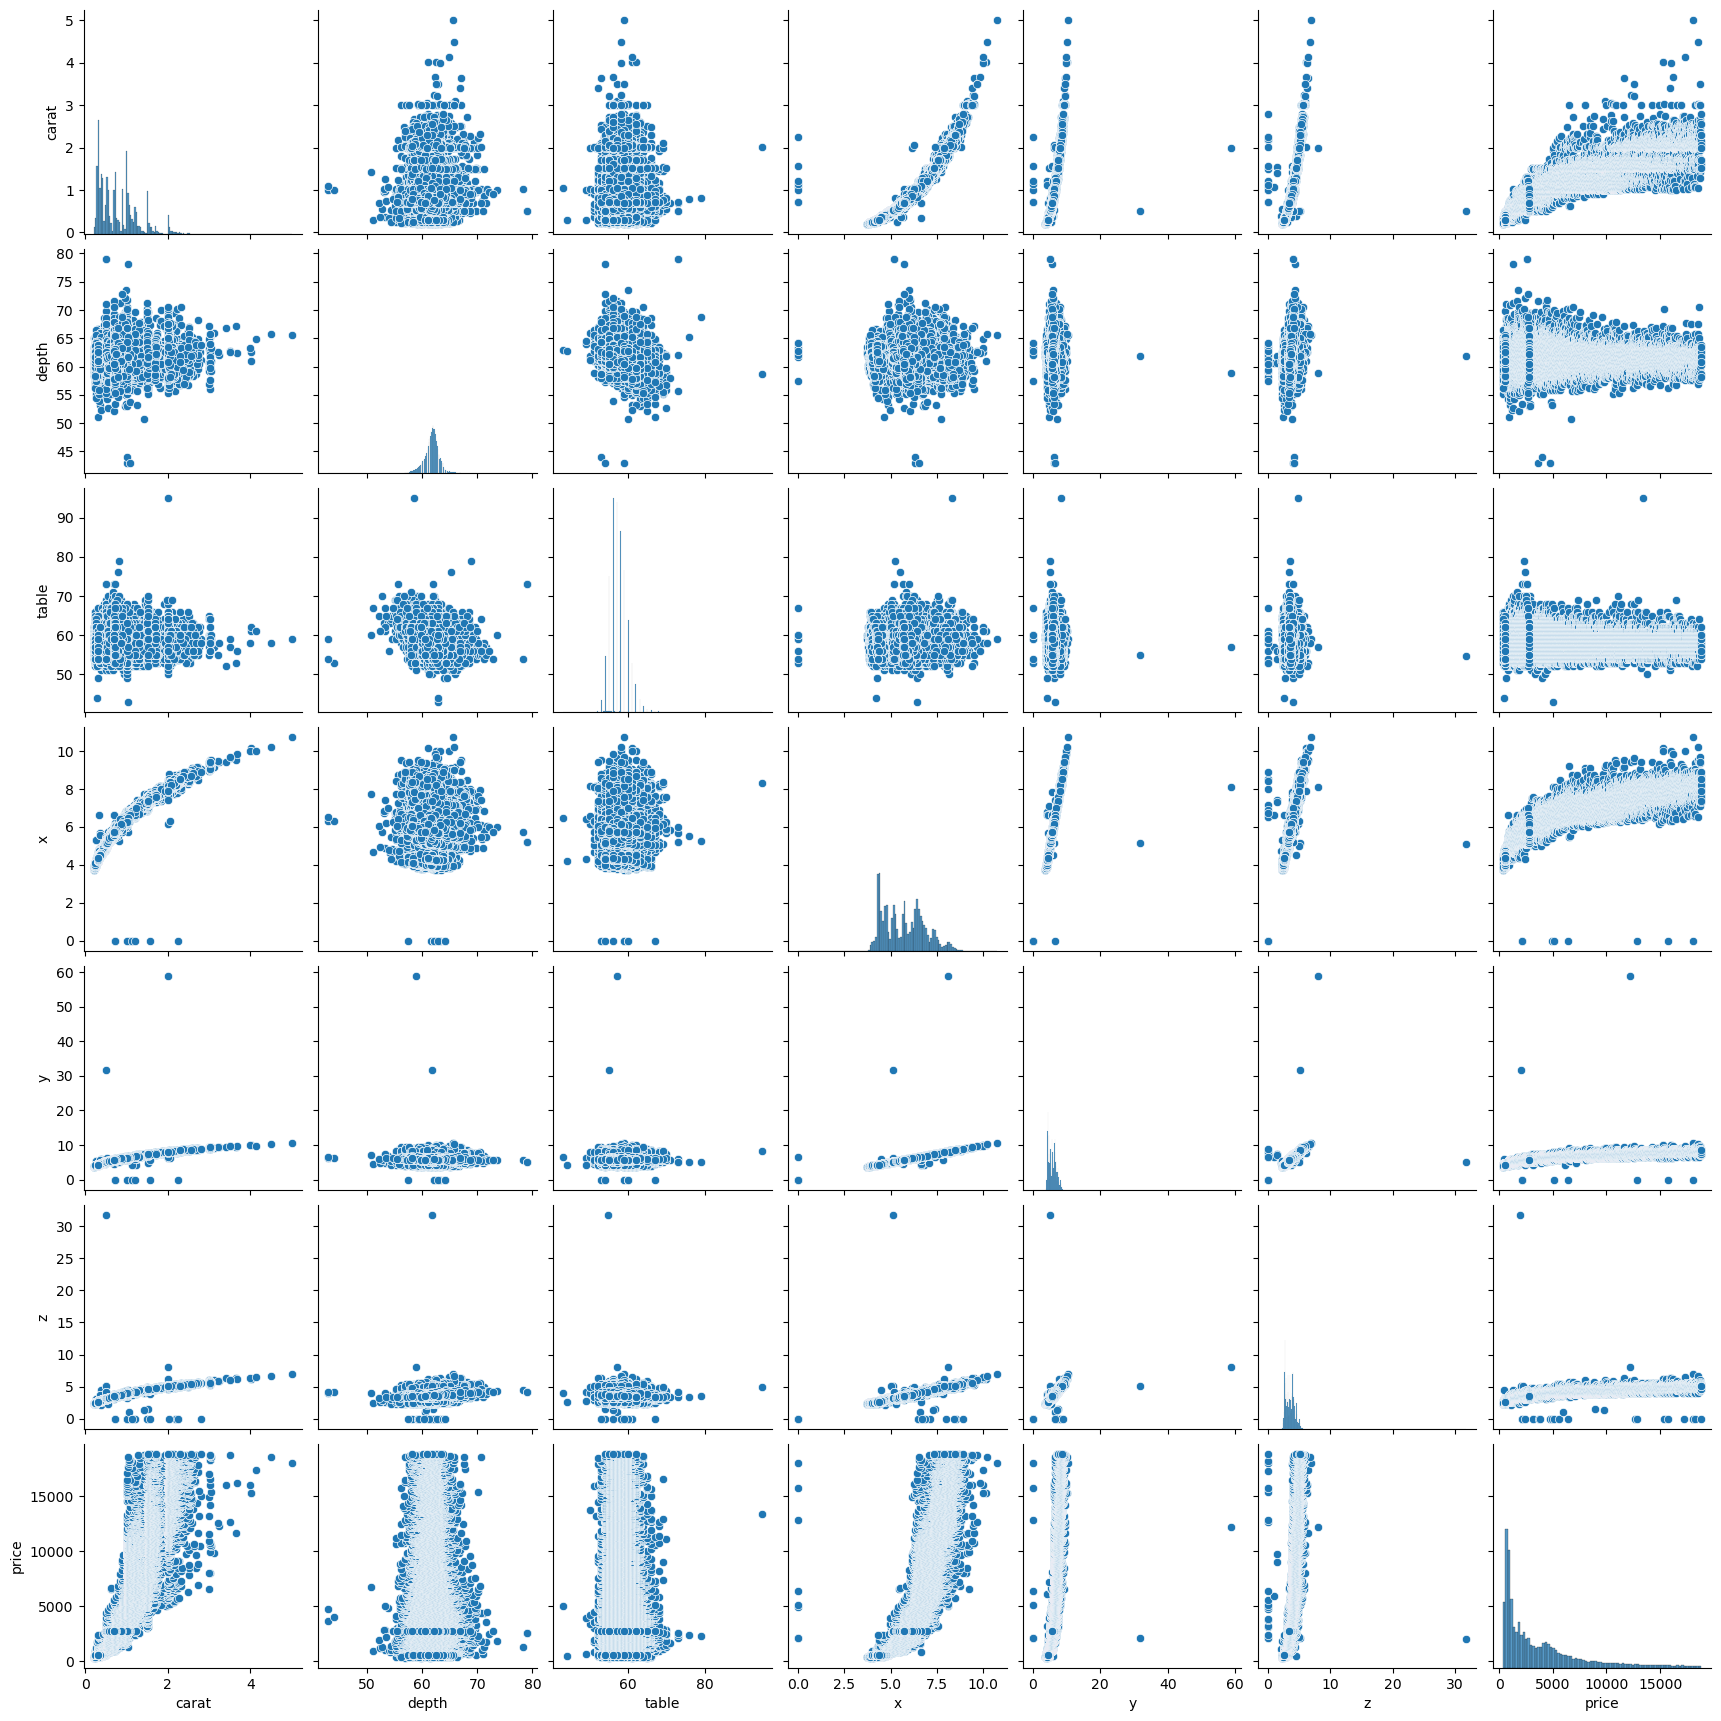

In [9]:
sns.pairplot(data=df[['carat', 'depth', 'table', 'x', 'y', 'z', 'price']]);

Price seems to correlate with carat, x, y, and z. What if we calculate the volume from the x, y, z dimensions?

In [3]:
df['volume'] = df['x'] * df['y'] * df['z']

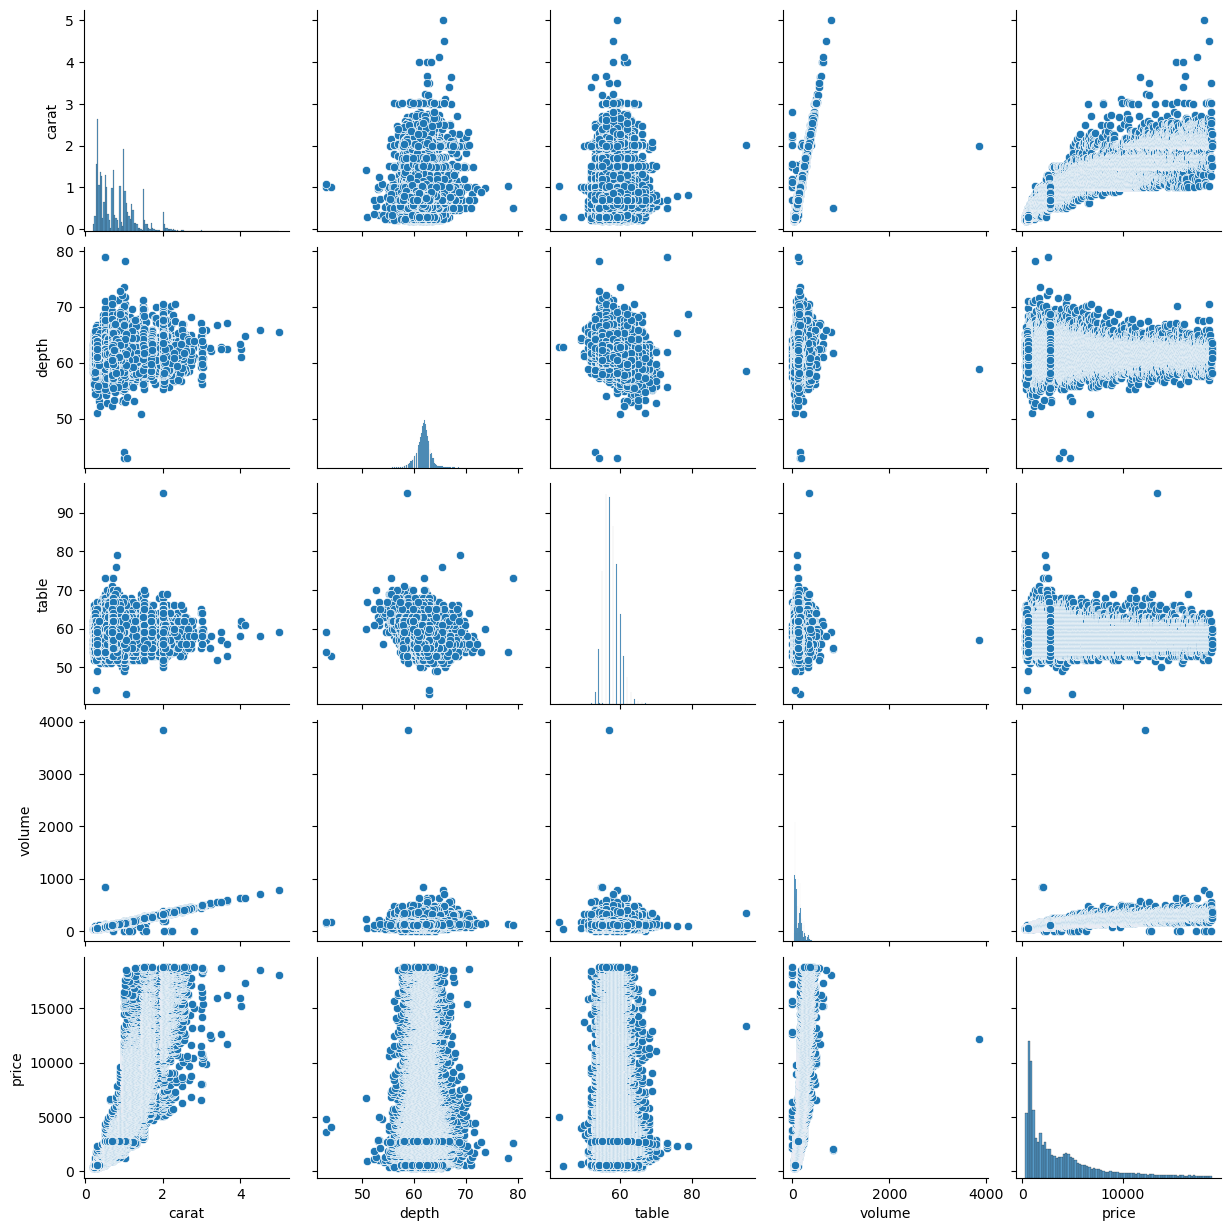

In [10]:

sns.pairplot(data=df[['carat', 'depth', 'table', 'volume', 'price']]);

Seems like the volume also correlates with the price and this is what I expected. Let's look at the categorical variables.

### Color vs Price

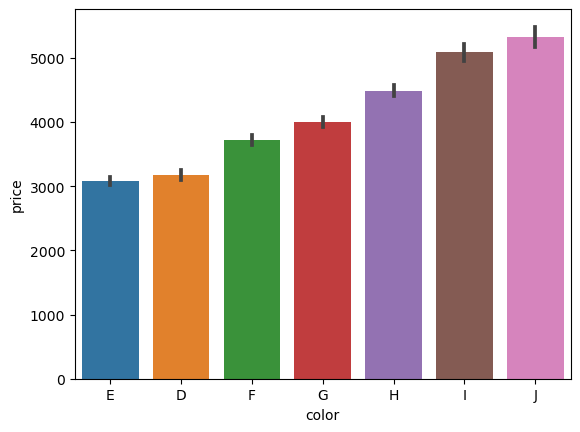

In [15]:
order = df.groupby('color').price.mean().sort_values(ascending=True).index
sns.barplot(data=df, x='color', y='price', order=order);

Different colors yield different prices, so this feature is highly informative.

### Clarity vs. Price

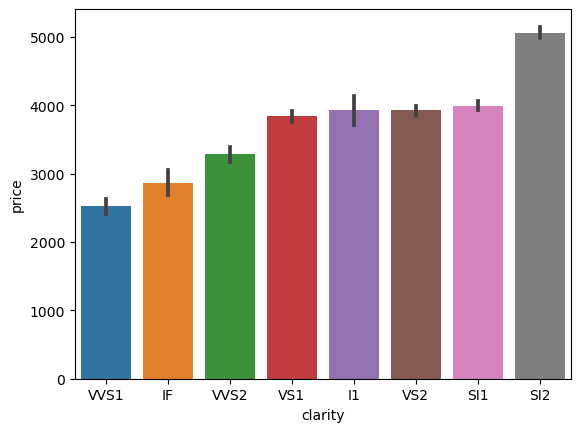

In [17]:
order = df.groupby('clarity').price.mean().sort_values(ascending=True).index
sns.barplot(data=df, x='clarity', y='price', order=order);

### Cut vs. Price

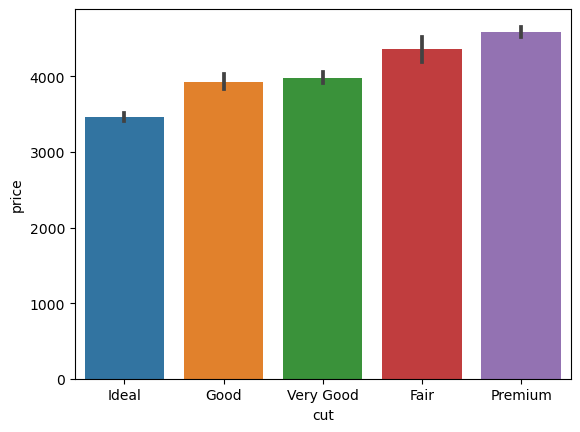

In [32]:
order = df.groupby('cut').price.mean().sort_values(ascending=True).index
sns.barplot(data=df, x='cut', y='price', order=order);

There is some variation across the clarity category. However, I1, SI1, VS1, VS2 are rather similar. But we'll keep it that way anyways. There is also variation across the cut with premium taking the lead.

### Summary
I will include the following features into the model: `carat`, `cut`, `volume`, `color`, and `clarity`.

In [4]:
df.drop(['x', 'y', 'z', 'depth', 'table', 'Unnamed: 0'], axis=1, inplace=True)

In [5]:
df.head()

,carat,cut,color,clarity,price,volume
0,0.23,Ideal,E,SI2,326,38.202030
1,0.21,Premium,E,SI1,326,34.505856
2,0.23,Good,E,VS1,327,38.076885
3,0.29,Premium,I,VS2,334,46.724580
4,0.31,Good,J,SI2,335,51.917250


In [42]:
dummy_pipeline = Pipeline([
    ('selector', DataFrameSelector(['cut', 'color', 'clarity'])),
    ('dummy', OneHotEncoder(sparse=False)),
])

full_pipeline = FeatureUnion(transformer_list=[
    ('dummy_pipeline', dummy_pipeline),
    ('num_pipeline', Pipeline([
        ('selector', DataFrameSelector(['carat', 'volume']))
    ])),
])

In [ ]:
mlflow.set_experiment("sgd-hyperopt")

In [ ]:
mlflow.set_tag("model", "sgd-regressor")
mlflow.log_params(params)

cat_cols = ['cut', 'color', 'clarity']
num_cols = ['carat', 'volume']

transformer = ColumnTransformer(
    [('categorical', OneHotEncoder(sparse=False), cat_cols), 
    ('numerical', StandardScaler(), num_cols)]
    )

full_pipeline = Pipeline([
    ('preprocessing', transformer),
    #('regression', RandomForestRegressor(**params))
    ('regression', SGDRegressor(**params))
])
tt = TransformedTargetRegressor(regressor=full_pipeline, transformer=StandardScaler())



#### Train Test Split

In [6]:
X = df.drop(['price'] , axis=1)
y = df['price']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)


## Trainig and experiment tracking
### Random Forest Regressor

In [40]:
HPO_EXPERIMENT_NAME = "random-forest-hyperopt"
EXPERIMENT_NAME = "random-forest-search"

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.sklearn.autolog(disable=True)

2022/11/06 17:01:35 INFO mlflow.tracking.fluent: Experiment with name 'random-forest-search' does not exist. Creating a new experiment.


In [41]:
def objective(params):
    with mlflow.start_run():
        
        mlflow.set_tag("model", "random-forest")
        mlflow.log_params(params)

        cat_cols = ['cut', 'color', 'clarity']
        num_cols = ['carat', 'volume'] 

        transformer = ColumnTransformer(
        [('categorical', OneHotEncoder(sparse=False), cat_cols), 
        ('numerical', StandardScaler(), num_cols)]
        )

        full_pipeline = Pipeline([
            ('preprocessing', transformer),
            ('regression', RandomForestRegressor(**params))
            #('regression', SGDRegressor(**params))
        ])
        tt = TransformedTargetRegressor(regressor=full_pipeline, transformer=StandardScaler())

        tt.fit(X_train, y_train)
        y_pred = tt.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [42]:
SPACE = {
    'max_depth': scope.int(hp.quniform('max_depth', 1, 20, 1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 10, 50, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 4, 1)),
    'random_state': 42
}

In [43]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 1, 20, 1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 10, 50, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 4, 1)),
    'random_state': 42
}

In [44]:
rstate = np.random.default_rng(42)  # for reproducible results
num_trials = 50
fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=num_trials,
    trials=Trials(),
    rstate=rstate
)

100%|██████████| 50/50 [02:23<00:00,  2.87s/trial, best loss: 590.0023507433791]


{'max_depth': 16.0,
 'min_samples_leaf': 1.0,
 'min_samples_split': 5.0,
 'n_estimators': 50.0}

### SGD-Regressor

In [15]:
HPO_EXPERIMENT_NAME = "sgd-hyperopt"
EXPERIMENT_NAME = "sgd-search"

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.sklearn.autolog(disable=True)

2022/11/04 16:53:03 INFO mlflow.tracking.fluent: Experiment with name 'sgd-search' does not exist. Creating a new experiment.


In [16]:
search_space = {
    'alpha': hp.quniform('alpha', 0.00001, 0.001, 0.00005),
    'epsilon': hp.quniform('epsilon', 0.0001, 0.1, 0.0001),
    'eta0': hp.quniform('eta0', 0.001, 0.01, 0.001),
    'tol': hp.quniform('tol', 0.00001, 0.0001, 0.00005),
    'max_iter': 1000,
    'random_state': 42
}

In [17]:
def objective_sgd(params):
    with mlflow.start_run():
        
        mlflow.set_tag("model", "sgddregressor")
        mlflow.log_params(params)

        cat_cols = ['cut', 'color', 'clarity']
        num_cols = ['carat', 'volume'] 

        transformer = ColumnTransformer(
        [('categorical', OneHotEncoder(sparse=False), cat_cols), 
        ('numerical', StandardScaler(), num_cols)]
        )

        full_pipeline = Pipeline([
            ('preprocessing', transformer),
            ('regression', SGDRegressor(**params))
        ])
        tt = TransformedTargetRegressor(regressor=full_pipeline, transformer=StandardScaler())

        tt.fit(X_train, y_train)
        y_pred = tt.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [18]:
rstate = np.random.default_rng(42)  # for reproducible results
num_trials = 50
fmin(
    fn=objective_sgd,
    space=search_space,
    algo=tpe.suggest,
    max_evals=num_trials,
    trials=Trials(),
    rstate=rstate
)

100%|██████████| 50/50 [00:28<00:00,  1.75trial/s, best loss: 1285.6604269680404]


{'alpha': 0.0,
 'epsilon': 0.09330000000000001,
 'eta0': 0.009000000000000001,
 'tol': 0.0}

### xgboost

In [20]:
HPO_EXPERIMENT_NAME = "xgb-hyperopt"
EXPERIMENT_NAME = "xgb-search"

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.sklearn.autolog(disable=True)

2022/11/04 16:56:29 INFO mlflow.tracking.fluent: Experiment with name 'xgb-search' does not exist. Creating a new experiment.


In [33]:
import xgboost as xgb


NameError: name 'space' is not defined

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [37]:
xgb_model = xgb.XGBRegressor()
def objective_xgb(params):

    xgb_model = xgb.XGBRegressor(
    n_estimators = params['n_estimators'],
    max_depth = int(params['max_depth']),
    learning_rate = params['learning_rate'],
    gamma = params['gamma'],
    min_child_weight = params ['min_child_weight'],
    subsample = params['subsample'],
    colsample_bytree = params['colsample_bytree'],
    objective='reg:squarederror')

    with mlflow.start_run():
        
        mlflow.set_tag("model", "sgddregressor")
        mlflow.log_params(params)

        cat_cols = ['cut', 'color', 'clarity']
        num_cols = ['carat', 'volume'] 

        transformer = ColumnTransformer(
        [('categorical', OneHotEncoder(sparse=False), cat_cols), 
        ('numerical', StandardScaler(), num_cols)]
        )

        full_pipeline = Pipeline([
            ('preprocessing', transformer),
            ('regression', xgb_model)
        ])
        tt = TransformedTargetRegressor(regressor=full_pipeline, transformer=StandardScaler())

        tt.fit(X_train, y_train)
        y_pred = tt.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [38]:
search_space = {
    'max_depth': hp.choice('max_depth', range(5, 30, 1)),
    'learning_rate': hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    'n_estimators': hp.choice('n_estimators', range(20, 205, 5)),
    'gamma': hp.quniform('gamma', 0, 0.5, 0.01),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.quniform('subsample', 0.1, 1, 0.01),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1.0, 0.01)
}

In [39]:
rstate = np.random.default_rng(42)  # for reproducible results
num_trials = 50
fmin(
    fn=objective_xgb,
    space=search_space,
    algo=tpe.suggest,
    max_evals=num_trials,
    trials=Trials(),
    rstate=rstate
)

100%|██████████| 50/50 [05:59<00:00,  7.19s/trial, best loss: 574.6417725846699]


{'colsample_bytree': 0.8,
 'gamma': 0.33,
 'learning_rate': 0.06,
 'max_depth': 14,
 'min_child_weight': 1.0,
 'n_estimators': 32,
 'subsample': 0.9}